SL CW Part III

To  Do:

1. Get a working Python cersion of that Wolfram code
2. Understand what the question wants and break it down into concepts and topics
3. Break the question up into seub questions
4. Begin the real plan

### Random Notes


#### Alpha Matrix

What is $\alpha$?

- The $\alpha$ matrix is shaped like so: $\alpha_{ji}$ where it represents the importance of each class $j$ and each sample $i$. So it answers the question, how important is this training sample to to this class.

But then when it comses to test time how does that all work?

- Well, during test time, a new sample point comes in and we essentially compute the similarity between this test point and the training data. We compute this similarity using the kernel function. Alpha stores the information on how important each training point is for each class. The more wrong it was on a training point the more weight it will attach to that class-point pair/element in the $\alpha$ matrix.

- When the classifier is wrong then it will increase the alpha value for the class that it just predicted (wrongly) by 1 (kinda like for binary classification where he uses `sign(sum(...))`) and decreases the actual correct class by one.

## Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd


from sklearn.metrics import confusion_matrix
import seaborn as sns

### First, a test with the small dataset and copying his algo from Mathematica


The data is stored such that the first element is the label (from 0 to 9) and the rest of that row is the image

In [12]:



def load_data(file_path):
    return np.loadtxt(file_path)

# Load the  smaller train and test datasets
dtrain123 = load_data("dtrain123.dat")
dtest123 = load_data("dtest123.dat")


def plot_char(char):
    # extract the label
    label = char[0]
    pixel_values = char[1:].reshape(16, 16)
    plt.imshow(pixel_values, cmap='gray')
    plt.title(f"The number {int(label)}")
    plt.show()

# Plotting the first character in the training data
plot_char(dtrain123[0])

# Define the polynomial Kernel Function
def kerval(a, b, d=3):
    return np.dot(a, b) ** d


def mysign(x):
    return -1.0 if x <= 0.0 else 1.0



FileNotFoundError: dtrain123.dat not found.

In [ ]:
# This part was "translated" using chatGPT from the mathematica code

# Classifier Initialization
def clear_glb_cls(data, num_classes=3):
    global GLBcls
    GLBcls = np.zeros((num_classes, len(data)))

# Prediction Function
def class_pred_k(dat, pat, cl):
    return sum(cl[i] * kerval(pat, dat[i, 1:], d=30) for i in range(len(cl)))

# Training Function
def train_gen(dat):
    global GLBcls
    mistakes = 0
    for i, item in enumerate(dat):
        val = int(item[0])
        preds = [class_pred_k(dat, item[1:], GLBcls[j]) for j in range(3)]
        maxc, maxi = -np.inf, -1
        for j in range(3):
            y = 1.0 if val == j + 1 else -1.0
            if y * preds[j] <= 0:
                GLBcls[j, i] -= mysign(preds[j])
            if preds[j] > maxc:
                maxc, maxi = preds[j], j
        if maxi + 1 != val:
            mistakes += 1
    return mistakes

# Testing Function
def test_classifiers(dat, testdat):
    mistakes = 0
    for item in testdat:
        val = int(item[0])
        preds = [class_pred_k(dat, item[1:], GLBcls[j]) for j in range(3)]
        maxc, maxi = -np.inf, -1
        for j, pred in enumerate(preds):
            if pred > maxc:
                maxc, maxi = pred, j
        if maxi + 1 != val:
            mistakes += 1
    return mistakes / len(testdat)

# Demonstration Function
def demo(train, test, epochs=3):
    clear_glb_cls(train)
    for i in range(epochs):
        train_mistakes = train_gen(train)
        test_error = test_classifiers(train, test)
        print(f"Epoch {i+1}: Training Mistakes = {train_mistakes}, Test Error = {test_error * 100:.3f}%")



In [10]:

# Load the Data
dtrain123 = load_data("dtrain123.dat")
dtest123 = load_data("dtest123.dat")

# Run the Demonstration
# Here, we're choosing to run for 3 epochs, but you can modify this number as needed
demo(dtrain123, dtest123, epochs=3)

FileNotFoundError: dtrain123.dat not found.

## Kerel Perceptron for Full Dataset

#### Load in the full size dataset (`zipcombo_data.dat`)


In [ ]:

# Load the zipcombo.dat data
zipcombo_data = load_data("zipcombo.dat")

# What does it look like?
labels = zipcombo_data[:, 0]
images = zipcombo_data[:, 1:]


# What are we looking at?
print(f"Rows: {zipcombo_data.shape[0]}\nColumns: {zipcombo_data.shape[1]}")


# Split the dataset into training and testing sets
train_data, test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=42)

# Separate labels and images
train_labels = train_data[:, 0]
train_images = train_data[:, 1:]
test_labels = test_data[:, 0]
test_images = test_data[:, 1:]


NameError: name 'load_data' is not defined

#### Class distribution histogram

This way we can do a quick check for data distribution properties such as class imbalance.

In [9]:


def plot_label_distribution(labels):
    plt.figure(figsize=(10, 4),dpi=100)
    plt.hist(labels, bins=np.arange(11) - 0.5, rwidth=0.8, color='blue', alpha=0.7)
    plt.title("Distribution of Labels (Classes) in the Dataset",fontsize=18)
    plt.xlabel("Digit Label",fontsize=18)
    plt.ylabel("Frequency",fontsize=18)
    plt.xticks(range(10))
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Plotting label distribution for the training data
plot_label_distribution(train_labels)


NameError: name 'train_labels' is not defined

In [1]:
# This function compute the kernel matrix for the polynomial kerenel. Its adpated so it can also compute batches
# but since we're doing online learning we'll set the batch_size = 1

def polynomial_kernel_matrix(X1, X2, degree=3):
    return (np.dot(X1, X2.T) + 1) ** degree



In [2]:
class MultiClassKernelPerceptron:
    """
    The instances this class will create will store the model (weights), the type of kernel used (polynomial for now but Gaussian later on),
    the number of classes and any other learning setting parameters

    """

    # What variables will this class take?
    def __init__(self, num_classes,kernel_function, degree=3):
        self.num_classes = num_classes
        self.degree = degree
        self.kernel_function = kernel_function
        self.alpha = None
        self.train_data = None
        self.kernel_matrix = None

    # A function to fit the model by updateing the matrix alpha
    def fit(self, X, y, epochs=10, batch_size=100):

        # Initialising the matrix alpha
        # It starts off giving more extra attentian/importance to any particular class-point pair
        self.alpha = np.zeros((self.num_classes, X.shape[0]))
        self.train_data = X

        # lets compute the batch kernel matrix all at once, then access rows later
        # this should increase efficiency a bit
        self.kernel_matrix = self.kernel_function(X, X, self.degree)

        # Now too loop over the bacthes and update the weights/alpha elements accordingly
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                batch_X_indices = range(i, min(i + batch_size, X.shape[0]))
                self._update_weights(batch_X_indices, y)

    def _update_weights(self, batch_X_indices, y):
        """
        So we have a batch of input images and the corresponding labels.
        In order to speed things up a bit I pre computed the kernel matrix so we can just read the correct row
        that corresponds to the apropriate sample in the batch
        We need to loop over therefore each sample in the batch and make a prediction.
        The logic here is:
        1. If the prediction is incorrect then we need to say that this particular sample is more important!
        So we increase the weight (alpha) by 1. And we decrease the alpha element at the correct class by one for that example/point
        2. If the prediction is correct then we do nothing.

        """

        # Loop over the batches
        for i in batch_X_indices:

            # Accessing the individual kernel matrix entries we calculated earlier
            kernel_matrix_row_vector = self.kernel_matrix[i]
            prediction_scores = kernel_matrix_row_vector.dot(self.alpha.T)
            predicted = np.argmax(prediction_scores)
            true_label = int(y[i])
            if predicted != true_label:
                self.alpha[true_label, i] += 1
                self.alpha[predicted, i] -= 1

    def predict(self, x):

        # Lets populate the kernel matrix
        kernel_values = self.kernel_function(x, self.train_data, self.degree)

        # Then weight each prediction by the learned parameter alpha
        predictions = kernel_values.dot(self.alpha.T)

        # so we've now got a bunch of probabilities/confidences that each class is correct.
        # There are a few different ways of doing this but we could just take the maximum confidence (as the coursework says)
        return np.argmax(predictions, axis=1)


In [3]:
# Initialize the classifier with the number of classes and degree of the polynomial kernel
classifier = MultiClassKernelPerceptron(num_classes=10,kernel_function=polynomial_kernel_matrix, degree=3)

# Train the classifier on your training data
classifier.fit(train_images, train_labels,epochs=10,batch_size=1)

# Make predictions on new data
predictions = classifier.predict(test_images)

# Evaluate the classifier
accuracy = np.mean(predictions == test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


NameError: name 'train_images' is not defined

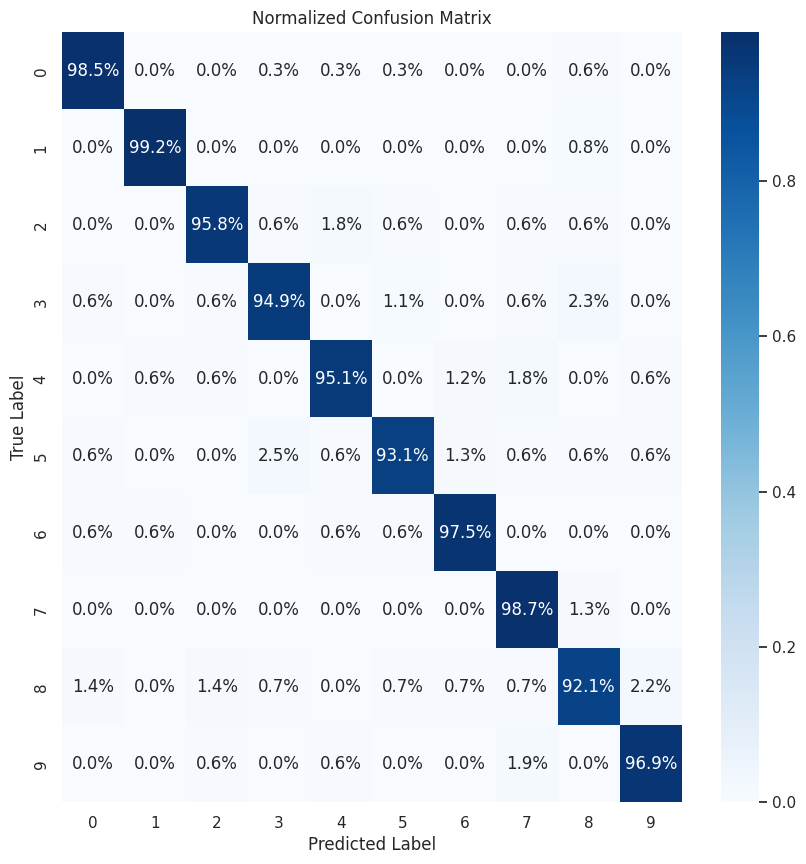

In [ ]:


def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".1%", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Assuming 'predictions' contains the predicted labels from the classifier
plot_confusion_matrix(test_labels, predictions, classes=np.arange(10))


## Experimental Protocol


Notes:

1. We need to report relative errors (so percentages)
2. In general it seems we need to perform 20 runs each time. Shuffling the data set and finding the mean and std
2. The final report should contain the following:


- Mean test and train error rates (with std) create a table (2x7 with each cell containing the std as well)
- 5-fold Cross-val to find the best $d$ (retrain on a 80:20 split once you've found the best value for $d$)
- Confusion matrix
- Find the 5 hardest to predict images and make comments as to whether or not its reasonable that they are hard to predict
- Repeat points 1 and 2 but using a Gaussian Kernel. Do the old cross-val again (to find the optimal $c$-Gaussian width)
- Research an alternative method to generalise the kernel perceptron and then once again repeat 1 and 2

To Do:
1. Create functions to automate training and testing of the classifier over the 20 runs with data splitting

Note: The method we're doing is known as "repeated random subsampling"


In [ ]:


def perform_random_split(zipcombo_data,random_state=42):

    # Split the dataset into training and testing sets with an 80:20 split
    # we want a different random state each time to get a unique split
    train_data, test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=random_state)

    # Separate labels and images
    train_labels = train_data[:, 0]
    train_images = train_data[:, 1:]
    test_labels = test_data[:, 0]
    test_images = test_data[:, 1:]

    return train_images,train_labels,test_images,test_labels


def train_test_classifier_for_d_and_20_runs(zipcombo_data, d, kernel_function, num_runs=20, epochs=10,batch_size=1):
    train_errors = []
    test_errors = []

    for run_index in tqdm(range(num_runs)):

        # Lets first create our new shuffled datasets for this run
        train_images, train_labels, test_images, test_labels = perform_random_split(zipcombo_data, random_state=run_index)

        # Initialize a new classifier for each new run with the specified degree
        classifier = MultiClassKernelPerceptron(num_classes=10,kernel_function=kernel_function, degree=d)

        # Then we need to train this classifier
        classifier.fit(train_images, train_labels, epochs=epochs,batch_size=batch_size)

        # Predict and calculate mistakes for train set
        train_predictions = classifier.predict(train_images)
        # How many mistakes were there?
        train_mistakes = np.sum(train_predictions != train_labels)
        train_error_rate = train_mistakes / len(train_labels)

        # Predict and calculate mistakes for test set
        test_predictions = classifier.predict(test_images)
        test_mistakes = np.sum(test_predictions != test_labels)
        test_error_rate = test_mistakes / len(test_labels)

        train_errors.append(train_error_rate)
        test_errors.append(test_error_rate)

    # Calculate mean and standard deviation of error rates over these 20 runs
    mean_train_error = np.mean(train_errors)
    std_train_error = np.std(train_errors)
    mean_test_error = np.mean(test_errors)
    std_test_error = np.std(test_errors)

    return mean_train_error, std_train_error, mean_test_error, std_test_error


Lets collect some results


**Quick Speed/Cost Review**


On my laptop it takes around 10 seconds to complete 10 epochs for d=3 and a batch_size of 100 ($\text{Single-Run-Single-d}$)

So to fully collect all of the results it would take around: $d_{\text{range}}*\text{num-runs}*T_{\text{Single-Run-Single-d}}$ so it will take around 23 minutes on my laptop (it didnt..). But my laptop is shit. Colab is not great but at least that took only 3 seconds and therefore would take 7 minutes to complete this experiment.

In [ ]:
results = {}
for d in range(1, 8):
    print(f"Collecting Results for d={d}")
    mean_train_error, std_train_error, mean_test_error, std_test_error = train_test_classifier_for_d_and_20_runs(
        zipcombo_data,
        d,
        polynomial_kernel_matrix,
        num_runs=20,
        epochs=10,
        batch_size=1 # so techniqually online learning now. Bit of a botch but it works
    )
    results[d] = {
        "Mean Train Error": mean_train_error,
        "Std Train Error": std_train_error,
        "Mean Test Error": mean_test_error,
        "Std Test Error": std_test_error
    }

# Print or store the results as needed
print(results)


On my laptop that took around 50 minutes but on colab it took 16mins. (Worth noting)

In [ ]:
# Given that that took a while, lets save those results so we dont have to do it again


df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.index.name = 'Degree'
df_results.reset_index(inplace=True)

csv_file_path = "kernel_perceptron_results_1.csv"
df_results.to_csv(csv_file_path, index=False)


In [ ]:
df_results

,Degree,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
0,1,0.060399,0.010165,0.087419,0.010907
1,2,0.005465,0.002859,0.039597,0.005073
2,3,0.001223,0.000650,0.032823,0.004522
3,4,0.000753,0.000516,0.031720,0.004345
4,5,0.000558,0.000583,0.029946,0.003936
5,6,0.000356,0.000214,0.032527,0.004461
6,7,0.000652,0.001747,0.032419,0.003384


Each of those errors is the proportion of incorrect predictions out of the total number of samples. Lets make a plot to visualise this.

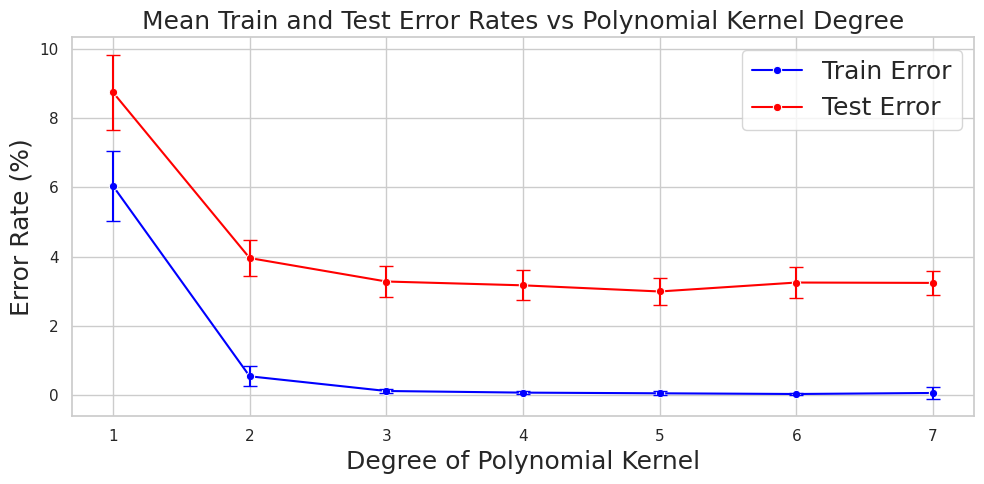

In [ ]:
df_results = pd.read_csv("kernel_perceptron_results_1.csv")


# Convert error rates to percentages
df_results['Mean Train Error'] *= 100
df_results['Mean Test Error'] *= 100
df_results['Std Train Error'] *= 100
df_results['Std Test Error'] *= 100


sns.set(style="whitegrid")

plt.figure(figsize=(10, 5),dpi=100)

# Plotting mean train error rates
sns.lineplot(x='Degree', y='Mean Train Error', data=df_results,
             label='Train Error', marker='o', color='blue')

# Add error bars for train error
plt.errorbar(df_results['Degree'], df_results['Mean Train Error'],
             yerr=df_results['Std Train Error'], fmt='none', capsize=5, color='blue')

# Plot mean test error rates
sns.lineplot(x='Degree', y='Mean Test Error', data=df_results,
             label='Test Error', marker='o', color='red')

# Add error bars for test error
plt.errorbar(df_results['Degree'], df_results['Mean Test Error'],
             yerr=df_results['Std Test Error'], fmt='none', capsize=5, color='red')


plt.title('Mean Train and Test Error Rates vs Polynomial Kernel Degree',fontsize=18)
plt.xlabel('Degree of Polynomial Kernel',fontsize=18)
plt.ylabel('Error Rate (%)',fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

# Show the plot
plt.show()


### Experimental Protocol Part 2


**Cross-validation**: Perform 20 runs : when using the 80% training data split from within to perform
5-fold cross-validation to select the “best” parameter $d^*$ then retrain on full 80% training set using $d^*$ and then record the test errors on the remaining 20%. Thus you will find 20 $d^*$ and 20 test errors.


Your final result will consist of a mean test error±std and a mean $d^*$ with std.


In [ ]:

from sklearn.model_selection import KFold

def cross_validate_and_train(zipcombo_data, d_values, num_runs=20, epochs=10, batch_size=1):
    test_errors = []
    best_d_values = []

    for run_index in tqdm(range(num_runs)):
        # Randomly split the data
        train_images, train_labels, test_images, test_labels = perform_random_split(zipcombo_data, random_state=run_index)

        # Cross-validation to find the best d from out range(1,8) - 1 to 7
        best_d, best_error = cross_validate(train_images, train_labels, d_values, epochs, batch_size,run_index)

        # Retrain with the best d
        classifier = MultiClassKernelPerceptron(num_classes=10, kernel_function=polynomial_kernel_matrix, degree=best_d)
        classifier.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

        # Test and record error
        test_predictions = classifier.predict(test_images)
        test_mistakes = np.sum(test_predictions != test_labels)
        test_error_rate = test_mistakes / len(test_labels)

        test_errors.append(test_error_rate)
        best_d_values.append(best_d)

    # Calculate mean and standard deviation of test errors and best d values
    mean_test_error = np.mean(test_errors)
    std_test_error = np.std(test_errors)
    mean_best_d = np.mean(best_d_values)
    std_best_d = np.std(best_d_values)

    return mean_test_error, std_test_error, mean_best_d, std_best_d



So we're performing 5-fold cross val which splits the data up into 5 folds, trains the data on k-1=4 folds while testing on the remaining set. This is repeated for all folds to result in an average test error. Then we do this 20 times with a shuffled dataset to get our final mean and std for the error rate.

In [ ]:
def cross_validate(train_images, train_labels, d_values, epochs, batch_size,run_index):

    print(f"Performing cross validation to find the best d value for this run ({run_index+1}/20)")
    # we're asked to use 5-fold cross validation
    kf = KFold(n_splits=5)
    best_d = None

    # Just so the first error is set to the best error:
    best_error = float('inf')

    for d in d_values:
        print(f"d={d}")
        errors = []
        for train_index, val_index in kf.split(train_images):
            X_train, X_val = train_images[train_index], train_images[val_index]
            y_train, y_val = train_labels[train_index], train_labels[val_index]

            # retrain a classifier with that shuffled data and that d value
            classifier = MultiClassKernelPerceptron(num_classes=10, kernel_function=polynomial_kernel_matrix, degree=d)
            classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

            val_predictions = classifier.predict(X_val)
            val_mistakes = np.sum(val_predictions != y_val)
            val_error_rate = val_mistakes / len(y_val)
            errors.append(val_error_rate)

        avg_error = np.mean(errors)
        if avg_error < best_error:
            best_error = avg_error
            best_d = d

    return best_d, best_error


In [ ]:
d_values = range(1, 8)
mean_test_error, std_test_error, mean_best_d, std_best_d = cross_validate_and_train(
    zipcombo_data,
    d_values,
    num_runs=20,
    epochs=10,
    batch_size=1 # Online Learning
)

# Print or store the results as needed
print("Mean Test Error: ", mean_test_error, "±", std_test_error)
print("Mean Best d: ", mean_best_d, "±", std_best_d)


Results for part 2

Mean Test Error:  0.031182795698924726 ± 0.0038657372069349567


Mean Best d:  4.95 ± 0.6689544080129827

In [ ]:
# saving results from part 2 of these "experimental protocols"


part_2_results = {
        "Mean Best d": mean_best_d,
        "Std Best d": std_best_d,
        "Mean Test Error": mean_test_error,
        "Std Test Error": std_test_error
    }




# Given that that took a while, lets save those results so we dont have to do it again



df_restuls_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
df_restuls_2.reset_index(inplace=True)

csv_file_path = "kernel_perceptron_results_2.csv"
df_restuls_2.to_csv(csv_file_path, index=False)




In [ ]:
df_restuls_2

,index,0
0,Mean Best d,4.950000
1,Std Best d,0.668954
2,Mean Test Error,0.031183
3,Std Test Error,0.003866


### Experimental Protocol Part 3


**Confusion matrix**:

Same as part 2 but then produce a confusion matrix. Here the goal is to find “confusions” thus if the true label (on the test set) was “7” and “2” was predicted then a “error” should recorded for “(7,2)”; the final output will be a 10 × 10 matrix where each cell contains a confusion error rate and its standard deviation (here you will have averaged over the 20 runs). Note the diagonal will be 0. In computing the error rate for a cell use

This is actually quite annoying because this could have been blended into part 2 and not wasted my bloody time.

In [ ]:
def calculate_error_rates(conf_matrix, counts):
    error_rates = conf_matrix / counts[:, None]
    np.fill_diagonal(error_rates, 0)  # Fill diagonal with 0s as they represent correct classifications
    return error_rates

def cross_validate_train_and_confusion(zipcombo_data, d_values, num_runs=20, epochs=10, batch_size=1):
    all_error_rates = []

    for run_index in tqdm(range(num_runs)):
        # Randomly split the data
        train_images, train_labels, test_images, test_labels = perform_random_split(zipcombo_data, random_state=run_index)

        # Cross-validation to find the best d from out range(1,8) - 1 to 7
        best_d, best_error = cross_validate(train_images, train_labels, d_values, epochs, batch_size,run_index)

        # Retrain with the best d
        classifier = MultiClassKernelPerceptron(num_classes=10, kernel_function=polynomial_kernel_matrix, degree=best_d)
        classifier.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

        # Test and record error
        test_predictions = classifier.predict(test_images)
        test_mistakes = np.sum(test_predictions != test_labels)
        test_error_rate = test_mistakes / len(test_labels)

        # Calculate confusion matrix
        current_confusion_matrix = confusion_matrix(test_labels, test_predictions, labels=np.arange(10))
        label_counts = np.bincount(test_labels.astype(int), minlength=10)

        # Calculate error rates for this run
        error_rates = calculate_error_rates(current_confusion_matrix, label_counts)
        all_error_rates.append(error_rates)

    # Calculate mean and standard deviation for each cell in the error rate matrices
    mean_error_rates = np.mean(all_error_rates, axis=0)
    std_error_rates = np.std(all_error_rates, axis=0)

    return mean_error_rates, std_error_rates


In [ ]:
d_values = range(1, 8)
mean_error_rates, std_error_rates = cross_validate_train_and_confusion(
    zipcombo_data,
    d_values,
    num_runs=20,
    epochs=10,
    batch_size=1
)


In [ ]:
# Convert the numpy arrays to pandas dataframes
df_mean_error_rates = pd.DataFrame(mean_error_rates, index=np.arange(10), columns=np.arange(10))
df_std_error_rates = pd.DataFrame(std_error_rates, index=np.arange(10), columns=np.arange(10))

# Save to CSV
df_mean_error_rates.to_csv("mean_error_rates.csv")
df_std_error_rates.to_csv("std_error_rates.csv")



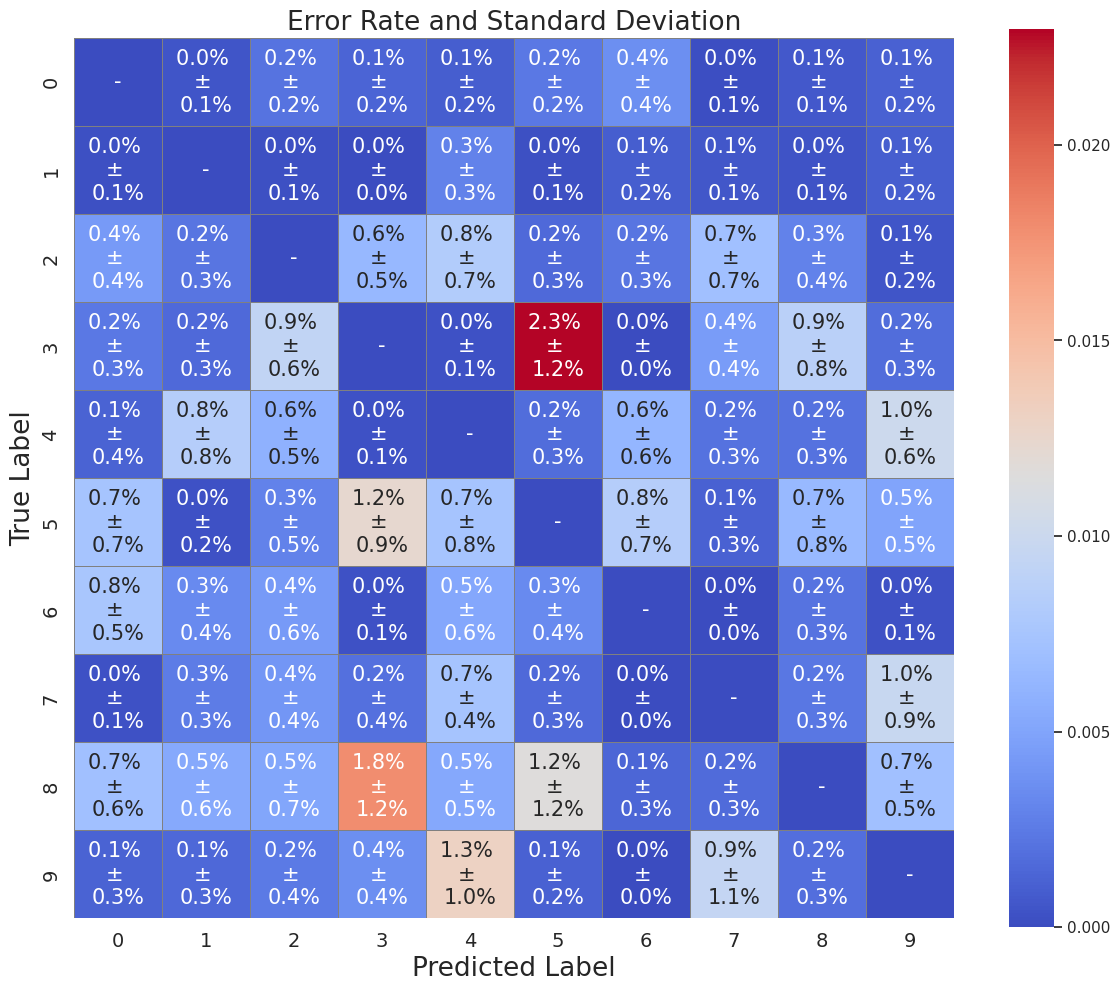

In [ ]:


def create_combined_matrix(mean_matrix, std_matrix):
    """Combines mean and standard deviation matrices into a formatted string matrix."""
    combined_matrix = np.vectorize(lambda mean, std: f"{mean*100:.1f}% \n± \n{std*100:.1f}%")(mean_matrix, std_matrix)
    np.fill_diagonal(combined_matrix, "-")  # Set diagonal entries to 0% ± 0%
    return combined_matrix

def plot_joint_confusion_matrix(df, combined_matrix, title, filename):
    """Plots a combined confusion matrix with heatmap."""
    plt.figure(figsize=(12, 10), dpi=100)
    sns.set(style="whitegrid")  # Setting the style to 'whitegrid' to add borders
    ax = sns.heatmap(df, annot=combined_matrix, fmt="", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 15}, linewidths=.5, linecolor='gray')

    # Styling
    plt.title(title, fontsize=19)
    plt.xlabel('Predicted Label', fontsize=19)
    plt.ylabel('True Label', fontsize=19)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Saving
    plt.savefig(filename, dpi=300)
    plt.show()


# Prepare the combined error and standard deviation matrix
combined_matrix = create_combined_matrix(mean_error_rates, std_error_rates)

# Convert the mean error rates matrix to a DataFrame for plotting
df_mean_errors = pd.DataFrame(mean_error_rates, index=np.arange(10), columns=np.arange(10))

# Plotting the combined confusion matrix
plot_joint_confusion_matrix(df_mean_errors, combined_matrix, "Error Rate and Standard Deviation", "combined_confusion_matrix.png")


* From the above figure we can see that 8s often get confused for 3s and 3s often for 5s. This will most likely be due to the shared double curve characterists. (They just look similar)

Discussion thus far as to what we have done


We have create a classifier that adpapts the standard perceptron, which is just a weighted sum of the inputs bassically, into a "kernel perceptron". This is done by computing the similarity between the training points and a new test point, this is stored in the kernel matrix. THe learning process here is the following:

1. We have a matrix called $\alpha$ with element $\alpha_{ji}$ for the $j^{th}$ class and the $i^{th}$ sample in the training dataset. $\alpha$ stores how important each training point is in the prediction of each class. If a new point comes in where loads of the alpha entries for one class are high then the final prediction is more likely to be that class.
2. **Learning**: So the way we learn the cassifier (update the alpha matrix) is if we predicted wrong class then we increase $\alpha_{ji}$ (where $i$ is of course that data point but $j$ is the class it tried predicting) by $1$ while at the same time decreasing the $\alpha_{ji}$ for the true class for that sample.
3. What is the error? How do we classify it?
- The test error is just the number of mistakes divided by test set size
- Although its slightly different for a confusion matrix because its now specific to each digit
4. **Prediction**: How have we made predictions?
- We, as the coursework asks for, have return a vector $\kappa \in \mathbb{R}^k$ where $\kappa_i$ is the confidence in the image being digit $i$
- But how do we actually make a prediction? It might be helpful to write out the equations actually:

**Equations**:

Polynomial Kernel

Choice of kernel:
- Why do we have that plus 1
$$K_d(x,x')=\langle x,x' \rangle^d=(x\cdot x')^d$$
where ..
what are the shapes of everything and in what spaces etc...


Making predictions using that Kernel



---


### Kernel Perceptron Classifier Notes


#### THe Learning Process

- **Alpha Matrix ($\alpha$)**:
    - **Purpose**: Stores the importance of each training point in predicting each class.
    - **Structure**: A matrix where $\alpha_{ji}$ corresponds to the importance of the $i^{th}$ training sample for the $j^{th}$ class.
    - **Update Rule**: If the prediction is wrong, increase $\alpha_{ji}$ for the predicted class and decrease it for the actual class of the sample.

#### 3. Error and Prediction

- **Test Error**: Calculated as the number of mistakes divided by the size of the test set.
- **Confusion Matrix**: Provides a digit-specific error representation, indicating how often each digit is misclassified as another.

#### 4. Making Predictions

- **Output Vector ($\kappa$)**: The classifier returns a vector $\kappa \in \mathbb{R}^k$, where $\kappa_i$ represents the confidence in predicting digit $i$.

### Equations and Details

#### Polynomial Kernel Equation

The polynomial kernel used in this classifier is defined as:

$$ K(x, y) = (x \cdot y + 1)^d $$

- **Where**:
    - $x, y$ are feature vectors (in this case, pixel values of images).
    - $d$ is the degree of the polynomial, a hyperparameter.
    - $\cdot$ denotes the dot product between vectors.
- **Reason for +1**: The +1 in the polynomial kernel equation is a form of regularization that allows the kernel to model not only the feature interactions (through the dot product) but also the individual feature influence. This inclusion helps to represent not only the high-dimensional interactions but also the original feature space, contributing to a richer feature mapping.

#### Prediction Mechanism

To make predictions using this kernel, we use the following approach:

1. **Kernel Computation**: For a test point $x$, compute the kernel value with each training point. This is vectorized across all training points for efficiency.

2. **Score Calculation**: For each class $j$, calculate a score as follows:

   $$ \text{Score}_j(x) = \sum_{i=1}^{n} \alpha_{ji} \cdot K(x, x_i) $$

   - $n$ is the number of training samples.
   - $x_i$ is the $i^{th}$ training sample.
   - $\alpha_{ji}$ is the importance of the $i^{th}$ sample for class $j$, as learned during training.

3. **Confidence Vector and Prediction**:
    - Compute the confidence vector $\kappa$, where each element $\kappa_j = \text{Score}_j(x)$.
    - The predicted class is the one with the highest score: $\text{Prediction} = \arg\max_j \kappa_j$.



Part 4 of Experimental Protocols

We need to find the hardest 5 images to predict the label of

* Which image input has the highest error rate over those 20 runs?
* So lets stick with our optimal d value of $d^*=4.9\pm0.7$. It'll be a similar structure as before actually just not also looping over a range of $d$ values.



In [ ]:


def perform_random_split(zipcombo_data,random_state=42):

    # Split the dataset into training and testing sets with an 80:20 split
    # we want a different random state each time to get a unique split
    train_data, test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=random_state)

    # Separate labels and images
    train_labels = train_data[:, 0]
    train_images = train_data[:, 1:]
    test_labels = test_data[:, 0]
    test_images = test_data[:, 1:]

    return train_images,train_labels,test_images,test_labels


def part_4_of_the_bloody_CW(zipcombo_data, d, kernel_function, num_runs=20, epochs=10,batch_size=1):
    # I just copied this from part 1

    misclassified_images = {}  # Dictionary to store (image, label): count


    for run_index in tqdm(range(num_runs)):

        # Lets first create our new shuffled datasets for this run
        train_images, train_labels, test_images, test_labels = perform_random_split(zipcombo_data, random_state=run_index)

        # Initialize a new classifier for each new run with the specified degree
        classifier = MultiClassKernelPerceptron(num_classes=10,kernel_function=kernel_function, degree=d)

        # Then we need to train this classifier
        classifier.fit(train_images, train_labels, epochs=epochs,batch_size=batch_size)

        # Predict and calculate mistakes for train set
        train_predictions = classifier.predict(train_images)
        # How many mistakes were there?
        train_mistakes = np.sum(train_predictions != train_labels)
        train_error_rate = train_mistakes / len(train_labels)

        # Predict and calculate mistakes for test set
        test_predictions = classifier.predict(test_images)
        test_mistakes = np.sum(test_predictions != test_labels)
        test_error_rate = test_mistakes / len(test_labels)


        # counting the misclassifications
        for i, (image, label) in enumerate(zip(test_images, test_labels)):
            if test_predictions[i] != label:
                key = (tuple(image), label)  # Using tuple(image) as key since arrays are not hashable
                misclassified_images[key] = misclassified_images.get(key, 0) + 1



    return misclassified_images


In [ ]:
d_star = 5
misclassified_images = part_4_of_the_bloody_CW(zipcombo_data, d_star, polynomial_kernel_matrix)

# Sort the misclassified images by their misclassification count (x[1] is accessing the missclassification count...)
sorted_misclassified = sorted(misclassified_images.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 misclassified images
top_5_misclassified = sorted_misclassified[:5]


100%|██████████| 20/20 [04:05<00:00, 12.26s/it]


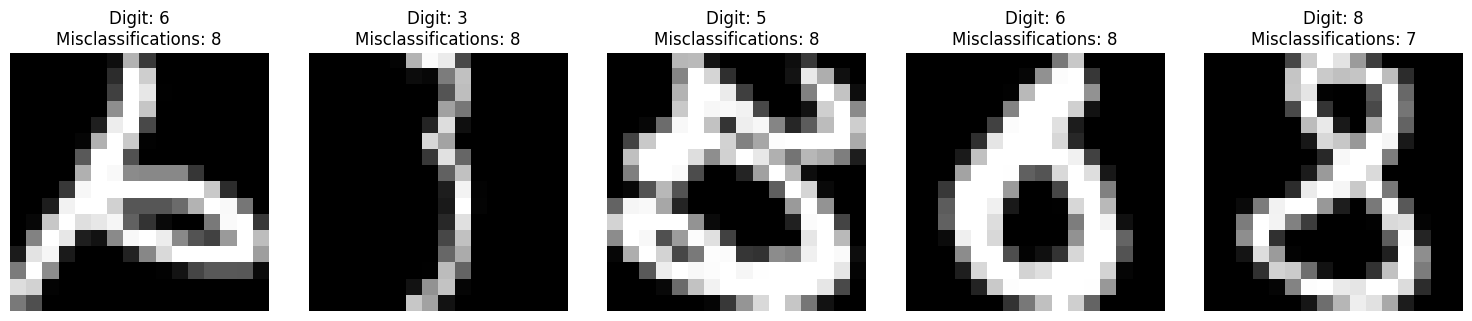

In [ ]:
def visualize_images(images_with_labels_counts, filename):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, 5, figsize=(15, 3), dpi=100)

    # Display each image in its subplot
    for ax, ((image, label), count) in zip(axes, images_with_labels_counts):
        ax.imshow(np.array(image).reshape(16, 16), cmap='gray')
        ax.set_title(f"Digit: {int(label)}\nMisclassifications: {count}", fontsize=12)
        ax.axis('off')

        # Adding white borders around individual images
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(2)

    # Layout adjustment and saving the figure
    plt.tight_layout(pad=0.5)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Prepare the top 5 misclassified images with their counts
images_with_labels_counts = [((image, label), misclassified_images[(tuple(image), label)]) for (image, label), _ in top_5_misclassified]

# Visualize and save the top 5 misclassified images
visualize_images(images_with_labels_counts, "top_5_misclassified_images_with_missclassifications.png")


Some Comments:
(Think more on this though)


* The classifier's performance can be mostly be attributed to two factors. Firstly, the low resolution of the 16x16 images restricts the model's ability to discern fine features which can be critical in the model's abiltity to classify a digit. (That 3 for instance..)

* Secondly, the classifier's accuracy is influenced by the representativeness of the training data. For instance, in the case of the misclassified '6' shown in the far-left plot, the classifier's error likely stems from that extended vertical tail, a feature rarely, if ever, observed in the training dataset.
* Such features can lead the classifier to associate the image with a more commonly seen pattern, like a '1', in instances where elongated vertical lines are predominant.

Experimental Protocol 5

Repeat steps 1 and 2 but just chnaging the kernel.

1: Doing the 20 runs, 10 epochs, and a batch_size of 1. Returning the train and test error rates but with a Gaussian Kernel. We could just use our function: `train_test_classifier_for_d_and_20_runs(zipcombo_data, d, kernel_function, num_runs=20, epochs=10,batch_size=1)` but of course we could give it any old d because we wont need it as an input for the kernel function

The Gaussian Kernel:

$$K(\mathbf{p},\mathbf{q})=e^{-c||\mathbf{p}-\mathbf{q}||^2}$$

where $c$ is like the inverse width of the Gaussian, $p$ and $q$ are input vectors.

In [ ]:
# Each time you see d or "degree" this time it is just a placeholder for c (avoids rewriting new code)

In [ ]:
def gaussian_kernel_matrix(X1, X2, c=1):
    # It looks a little weird cause its vectorised
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-c * sq_dists)


first of all we need to do some prelimininary tests to find  good starting point for c. THen we'll sweep over a range of c values in our cross-validation.

In [ ]:

# rather than d we now have the width of the Gaussian (c)
# SAME STRUCTURE AS BEFORE, I DONT KNOW WHY I'M TYPING IN CAPS

results_gaussian = {}
c_values = [0.0001,0.001,0.01,0.1, 1, 10]  # Example range of c values

for c in c_values:
    print(f"Collecting Results for c={c}")
    mean_train_error, std_train_error, mean_test_error, std_test_error = train_test_classifier_for_d_and_20_runs(
        zipcombo_data,
        d=c,  # Treating d as c for the Gaussian kernel
        kernel_function=gaussian_kernel_matrix,
        num_runs=20,
        epochs=10,
        batch_size=1  # Online learning still :) - technically
    )
    results_gaussian[c] = {
        "Mean Train Error": mean_train_error,
        "Std Train Error": std_train_error,
        "Mean Test Error": mean_test_error,
        "Std Test Error": std_test_error
    }


100%|██████████| 20/20 [04:01<00:00, 12.07s/it]


100%|██████████| 20/20 [03:05<00:00,  9.26s/it]


100%|██████████| 20/20 [03:03<00:00,  9.18s/it]


100%|██████████| 20/20 [03:07<00:00,  9.35s/it]


100%|██████████| 20/20 [03:05<00:00,  9.29s/it]


100%|██████████| 20/20 [03:30<00:00, 10.54s/it]


In [ ]:
# So now we have done our initial sweep what range shall we choose?

# saving preliminary results



df_results_gaussian = pd.DataFrame.from_dict(results_gaussian, orient='index')
df_results_gaussian.reset_index(inplace=True)

csv_file_path = "Gaussian_Kernel_preliminary_results.csv"
df_results_gaussian.to_csv(csv_file_path, index=False)




In [ ]:
df_results_gaussian

,index,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
0,0.001000,0.054087,0.018740,0.077312,0.017878
1,0.005333,0.002494,0.001009,0.035376,0.003589
2,0.009667,0.000699,0.000557,0.031102,0.004200
3,0.014000,0.000363,0.000376,0.030188,0.003655
4,0.018333,0.000316,0.000260,0.030296,0.003922
5,0.022667,0.000350,0.000404,0.031290,0.004296
6,0.027000,0.000195,0.000138,0.031855,0.004098
7,0.031333,0.000215,0.000210,0.034113,0.004363
8,0.035667,0.000276,0.000377,0.035457,0.004252
9,0.040000,0.000437,0.001084,0.035699,0.002917


Then we can save those results as a csv using pandas
So $c=0.1$ was the lowest mean test error rate. It resulted in a test error of $0.048$

Quick Note:

* Low $c$ (so wider Gaussian) can be good to reduce overfitting because it results in a smoother descision boundry
* High $c$ can capture more fine details but can leed to overfitting

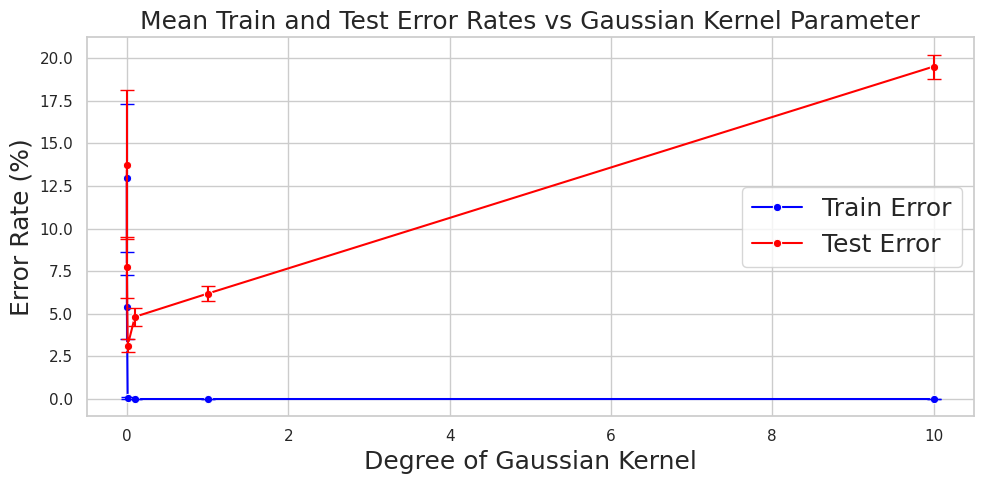

In [ ]:
df_results = pd.read_csv("Gaussian_Kernel_preliminary_results.csv")


# Convert error rates to percentages
df_results['Mean Train Error'] *= 100
df_results['Mean Test Error'] *= 100
df_results['Std Train Error'] *= 100
df_results['Std Test Error'] *= 100


sns.set(style="whitegrid")

plt.figure(figsize=(10, 5),dpi=100)

# Plotting mean train error rates
sns.lineplot(x='index', y='Mean Train Error', data=df_results,
             label='Train Error', marker='o', color='blue')

# Add error bars for train error
plt.errorbar(df_results['index'], df_results['Mean Train Error'],
             yerr=df_results['Std Train Error'], fmt='none', capsize=5, color='blue')

# Plot mean test error rates
sns.lineplot(x='index', y='Mean Test Error', data=df_results,
             label='Test Error', marker='o', color='red')

# Add error bars for test error
plt.errorbar(df_results['index'], df_results['Mean Test Error'],
             yerr=df_results['Std Test Error'], fmt='none', capsize=5, color='red')


plt.title('Mean Train and Test Error Rates vs Gaussian Kernel Parameter',fontsize=18)
plt.xlabel('Degree of Gaussian Kernel',fontsize=18)
plt.ylabel('Error Rate (%)',fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

# Show the plot
plt.show()


Lets do that again but zooming in a bit to the

In [ ]:

# rather than d we now have the width of the Gaussian (c)
# SAME STRUCTURE AS BEFORE, I DONT KNOW WHY I'M TYPING IN CAPS

results_gaussian = {}
c_values = np.linspace(0.001,0.01,10)  # Example range of c values

for c in c_values:
    print(f"Collecting Results for c={c}")
    mean_train_error, std_train_error, mean_test_error, std_test_error = train_test_classifier_for_d_and_20_runs(
        zipcombo_data,
        d=c,  # Treating d as c for the Gaussian kernel
        kernel_function=gaussian_kernel_matrix,
        num_runs=20,
        epochs=10,
        batch_size=1  # Online learning still :) - technically
    )
    results_gaussian[c] = {
        "Mean Train Error": mean_train_error,
        "Std Train Error": std_train_error,
        "Mean Test Error": mean_test_error,
        "Std Test Error": std_test_error
    }


100%|██████████| 20/20 [02:51<00:00,  8.55s/it]


100%|██████████| 20/20 [02:53<00:00,  8.69s/it]


100%|██████████| 20/20 [02:52<00:00,  8.63s/it]


100%|██████████| 20/20 [02:49<00:00,  8.50s/it]


100%|██████████| 20/20 [02:53<00:00,  8.67s/it]


100%|██████████| 20/20 [02:53<00:00,  8.65s/it]


100%|██████████| 20/20 [02:50<00:00,  8.52s/it]


100%|██████████| 20/20 [02:50<00:00,  8.52s/it]


100%|██████████| 20/20 [02:50<00:00,  8.50s/it]


100%|██████████| 20/20 [02:52<00:00,  8.64s/it]


Its clear that with $\approx c \geq 1$ the classifier is not generalising well and is heavilly overfitting. We need to widen the Gaussian kernel by reducing $c$. A more suitable value to center the range around would be:

In [ ]:
# saving results from part 5



df_results_gaussian = pd.DataFrame.from_dict(results_gaussian, orient='index')
df_results_gaussian.reset_index(inplace=True)

csv_file_path = "kernel_perceptron_results_5_Gaussian_kernel_repeat_of_part_1.csv"
df_results_gaussian.to_csv(csv_file_path, index=False)




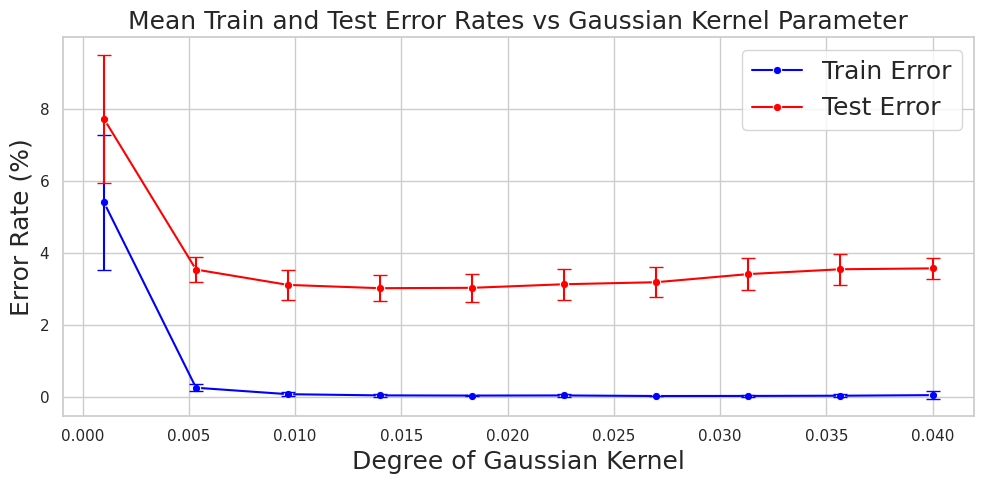

In [ ]:
df_results = pd.read_csv("kernel_perceptron_results_5_Gaussian_kernel_repeat_of_part_1.csv")


# Convert error rates to percentages
df_results['Mean Train Error'] *= 100
df_results['Mean Test Error'] *= 100
df_results['Std Train Error'] *= 100
df_results['Std Test Error'] *= 100


sns.set(style="whitegrid")

plt.figure(figsize=(10, 5),dpi=100)

# Plotting mean train error rates
sns.lineplot(x='index', y='Mean Train Error', data=df_results,
             label='Train Error', marker='o', color='blue')

# Add error bars for train error
plt.errorbar(df_results['index'], df_results['Mean Train Error'],
             yerr=df_results['Std Train Error'], fmt='none', capsize=5, color='blue')

# Plot mean test error rates
sns.lineplot(x='index', y='Mean Test Error', data=df_results,
             label='Test Error', marker='o', color='red')

# Add error bars for test error
plt.errorbar(df_results['index'], df_results['Mean Test Error'],
             yerr=df_results['Std Test Error'], fmt='none', capsize=5, color='red')


plt.title('Mean Train and Test Error Rates vs Gaussian Kernel Parameter',fontsize=18)
plt.xlabel('Degree of Gaussian Kernel',fontsize=18)
plt.ylabel('Error Rate (%)',fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# lookin at the plot again we should coose our range of c values to be between 0.01 and 0.03 in order to find our final best 20 c values.


Part 5.2

Finding the optimal c value with cross val

In [ ]:
def cross_validate_c_values(train_images, train_labels, c_values, epochs, batch_size,run_index,kernel_function):

    print(f"Performing cross validation to find the best c value for this run ({run_index+1}/20)")
    # we're asked to use 5-fold cross validation
    kf = KFold(n_splits=5)
    best_d = None

    # Just so the first error is set to the best error:
    best_error = float('inf')

    for c in c_values:
        print(f"c={c}")
        errors = []
        for train_index, val_index in kf.split(train_images):
            X_train, X_val = train_images[train_index], train_images[val_index]
            y_train, y_val = train_labels[train_index], train_labels[val_index]

            # retrain a classifier with that shuffled data and that d value
            classifier = MultiClassKernelPerceptron(num_classes=10, kernel_function=kernel_function, degree=c)
            classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

            val_predictions = classifier.predict(X_val)
            val_mistakes = np.sum(val_predictions != y_val)
            val_error_rate = val_mistakes / len(y_val)
            errors.append(val_error_rate)

        avg_error = np.mean(errors)
        if avg_error < best_error:
            best_error = avg_error
            best_c = c

    return best_c, best_error




def cross_validate_and_train_c_values(zipcombo_data, c_values,kernel_function, num_runs=20, epochs=10, batch_size=1):
    test_errors = []
    best_c_values = []

    for run_index in tqdm(range(num_runs)):
        # Randomly split the data
        train_images, train_labels, test_images, test_labels = perform_random_split(zipcombo_data, random_state=run_index)

        # Cross-validation to find the best c from out np.linspace(0.01,0.03,3)
        best_c, best_error = cross_validate_c_values(train_images, train_labels, c_values, epochs, batch_size,run_index,kernel_function)

        # Retrain with the best c
        classifier = MultiClassKernelPerceptron(num_classes=10, kernel_function=kernel_function, degree=best_c)
        classifier.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

        # Test and record error
        test_predictions = classifier.predict(test_images)
        test_mistakes = np.sum(test_predictions != test_labels)
        test_error_rate = test_mistakes / len(test_labels)

        test_errors.append(test_error_rate)
        best_c_values.append(best_c)

    # Calculate mean and standard deviation of test errors and best d values
    mean_test_error = np.mean(test_errors)
    std_test_error = np.std(test_errors)
    mean_best_c = np.mean(best_c_values)
    std_best_c = np.std(best_c_values)

    return mean_test_error, std_test_error, mean_best_c, std_best_c



In [ ]:
c_values = np.linspace(0.01,0.03,3)
mean_test_error, std_test_error, mean_best_c, std_best_c = cross_validate_and_train_c_values(
    zipcombo_data,
    c_values,
    kernel_function = gaussian_kernel_matrix,
    num_runs=20,
    epochs=10,
    batch_size=1 # Online Learning
)

# Print or store the results as needed
print("Mean Test Error: ", mean_test_error, "±", std_test_error)
print("Mean Best c: ", mean_best_c, "±", std_best_c)


  0%|          | 0/20 [00:00<?, ?it/s]

Performing cross validation to find the best c value for this run (1/20)
c=0.01
c=0.019999999999999997
c=0.03


  5%|▌         | 1/20 [01:12<22:53, 72.31s/it]

Performing cross validation to find the best c value for this run (2/20)
c=0.01
c=0.019999999999999997
c=0.03


 10%|█         | 2/20 [02:22<21:17, 70.98s/it]

Performing cross validation to find the best c value for this run (3/20)
c=0.01
c=0.019999999999999997
c=0.03


 15%|█▌        | 3/20 [03:29<19:37, 69.29s/it]

Performing cross validation to find the best c value for this run (4/20)
c=0.01
c=0.019999999999999997
c=0.03


 20%|██        | 4/20 [04:35<18:07, 67.98s/it]

Performing cross validation to find the best c value for this run (5/20)
c=0.01
c=0.019999999999999997
c=0.03


 25%|██▌       | 5/20 [05:41<16:47, 67.16s/it]

Performing cross validation to find the best c value for this run (6/20)
c=0.01
c=0.019999999999999997
c=0.03


 30%|███       | 6/20 [06:58<16:26, 70.45s/it]

Performing cross validation to find the best c value for this run (7/20)
c=0.01
c=0.019999999999999997
c=0.03


 35%|███▌      | 7/20 [08:03<14:55, 68.91s/it]

Performing cross validation to find the best c value for this run (8/20)
c=0.01
c=0.019999999999999997
c=0.03


 40%|████      | 8/20 [09:11<13:43, 68.60s/it]

Performing cross validation to find the best c value for this run (9/20)
c=0.01
c=0.019999999999999997
c=0.03


 45%|████▌     | 9/20 [10:17<12:25, 67.77s/it]

Performing cross validation to find the best c value for this run (10/20)
c=0.01
c=0.019999999999999997
c=0.03


 50%|█████     | 10/20 [11:24<11:13, 67.38s/it]

Performing cross validation to find the best c value for this run (11/20)
c=0.01
c=0.019999999999999997
c=0.03


 55%|█████▌    | 11/20 [12:33<10:11, 68.00s/it]

Performing cross validation to find the best c value for this run (12/20)
c=0.01
c=0.019999999999999997
c=0.03


 60%|██████    | 12/20 [13:40<09:00, 67.57s/it]

Performing cross validation to find the best c value for this run (13/20)
c=0.01
c=0.019999999999999997
c=0.03


 65%|██████▌   | 13/20 [14:48<07:53, 67.65s/it]

Performing cross validation to find the best c value for this run (14/20)
c=0.01
c=0.019999999999999997
c=0.03


 70%|███████   | 14/20 [15:53<06:41, 66.98s/it]

Performing cross validation to find the best c value for this run (15/20)
c=0.01
c=0.019999999999999997
c=0.03


 75%|███████▌  | 15/20 [16:59<05:33, 66.65s/it]

Performing cross validation to find the best c value for this run (16/20)
c=0.01
c=0.019999999999999997
c=0.03


 80%|████████  | 16/20 [18:09<04:30, 67.57s/it]

Performing cross validation to find the best c value for this run (17/20)
c=0.01
c=0.019999999999999997
c=0.03


 85%|████████▌ | 17/20 [19:14<03:20, 66.92s/it]

Performing cross validation to find the best c value for this run (18/20)
c=0.01
c=0.019999999999999997
c=0.03


 90%|█████████ | 18/20 [20:22<02:14, 67.33s/it]

Performing cross validation to find the best c value for this run (19/20)
c=0.01
c=0.019999999999999997
c=0.03


 95%|█████████▌| 19/20 [21:27<01:06, 66.61s/it]

Performing cross validation to find the best c value for this run (20/20)
c=0.01
c=0.019999999999999997
c=0.03


100%|██████████| 20/20 [22:40<00:00, 68.01s/it]

Mean Test Error:  0.031720430107526884 ± 0.004133146471781198
Mean Best c:  0.013999999999999999 ± 0.004898979485566355


**Results**:

Mean Test Error:  0.0317 ± 0.0041

Mean Best c:  0.0140 ± 0.0049

In [ ]:
# saving results from part 2 of these "experimental protocols"


part_5_2_results = {
        "Mean Best c": mean_best_c,
        "Std Best c": std_best_c,
        "Mean Test Error": mean_test_error,
        "Std Test Error": std_test_error
    }




# Given that that took a while, lets save those results so we dont have to do it again



df_restuls_5_2 = pd.DataFrame.from_dict(part_5_2_results, orient='index')
df_restuls_5_2.reset_index(inplace=True)

csv_file_path = "kernel_perceptron_results_5_2.csv"
df_restuls_5_2.to_csv(csv_file_path, index=False)




In [ ]:
df_restuls_5_2

,index,0
0,Mean Best c,0.014000
1,Std Best c,0.004899
2,Mean Test Error,0.031720
3,Std Test Error,0.004133


Part 6

Choose (research) an alternate method to generalise the kernel perceptron to k-classes then repeat 1
and 2

* look into one-v-all and 1-v-1

* we could try to do an ensemble approach. lets do it.. actually no, because thats not "generalising" the perceptron from 2 to many classes

In [ ]:
#helpful code:

# Load the zipcombo.dat data
zipcombo_data = load_data("zipcombo.dat")

# What does it look like?
labels = zipcombo_data[:, 0]
images = zipcombo_data[:, 1:]

print(f"Rows: {zipcombo_data.shape[0]}\nColumns: {zipcombo_data.shape[1]}")


# Split the dataset into training and testing sets
train_data, test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=42)

# Separate labels and images
train_labels = train_data[:, 0]
train_images = train_data[:, 1:]
test_labels = test_data[:, 0]
test_images = test_data[:, 1:]


# Training ensemble of classifiers
best_c = 0.014 # for gauss
best_d = 5 # for poly
kernel = gaussian_kernel_matrix
#kernel = polynomial_kernel_matrix


classifier = MultiClassKernelPerceptron(num_classes=10,kernel_function=kernel, degree=best_c)# rememer "degree" is not actually a degree is the iverser width of the gaussian. Its just left there as a reminent of when i used a polynomial kernel

# Train the classifier on your training data
classifier.fit(train_images, train_labels,epochs=10,batch_size=1)

# Make predictions on new data
predictions = classifier.predict(test_images)

# Evaluate the classifier
accuracy = np.mean(predictions == test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



# # you'll have to write this function
# classifiers = train_ensemble_classifiers(zipcombo_data, kernel,best_d,num_classifiers=1, epochs=10, batch_size=1, random_state=42)



# what we could do is first split the data up using train_images, train_labels, test_images, test_labels = perform_random_split(zipcombo_data, random_state=run_index)
# and then looking at only the training data, shuffle that to train n classifiers as above. We will then use these as an ensemble of models to make predictions

Rows: 9298
Columns: 257


NameError: ignored

In [ ]:

def train_ensemble_classifiers(data, kernel_function, kernel_param, num_classifiers, epochs, batch_size, random_state):
    classifiers = []
    for i in tqdm(range(num_classifiers)):
        # Perform a random split on the training data
        sub_train_data, _ = train_test_split(data, test_size=0.2, random_state=random_state + i)

        # Separate labels and images
        train_labels = sub_train_data[:, 0]
        train_images = sub_train_data[:, 1:]

        # Initialize and train the classifier
        classifier = MultiClassKernelPerceptron(num_classes=10, kernel_function=kernel_function, degree=kernel_param)
        classifier.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

        classifiers.append(classifier)
    return classifiers



In [ ]:
# Initial split of the dataset
initial_train_data, final_test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=42)

# Separate labels and images for the final test set
final_test_labels = final_test_data[:, 0]
final_test_images = final_test_data[:, 1:]



# Training ensemble of classifiers
best_c = 0.014 # for gauss
best_d = 5 # for poly
kernel = gaussian_kernel_matrix
#kernel = polynomial_kernel_matrix

num_classifiers = 100  # Number of classifiers in the ensemble
classifiers = train_ensemble_classifiers(initial_train_data, kernel, best_c, num_classifiers=num_classifiers, epochs=10, batch_size=1, random_state=42)



100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


In [ ]:
def ensemble_predict(classifiers, test_images):
    # Each classifier makes predictions
    predictions = [classifier.predict(test_images) for classifier in classifiers]

    # Transpose to get predictions for each test image across all classifiers
    predictions = np.array(predictions).T

    # Use majority voting
    final_predictions = np.array([np.argmax(np.bincount(p)) for p in predictions])
    return final_predictions


In [ ]:
# Make predictions with the ensemble on the final test set
ensemble_predictions = ensemble_predict(classifiers, final_test_images)

# Evaluate the ensemble classifier
ensemble_accuracy = np.mean(ensemble_predictions == final_test_labels)
print(f"Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")



Results from the Ensemble Test (Although not really relevant to anything)

- An "ensemble" of 1: Accuracy of 96%
- An ensemble of 10: Accuracy of 97.2%
- An ensemble of 20: Accuracy of 97.9%
- An ensemble of 100: Accuracy of 97.9%